# Introduction to MLflow: Managing the Machine Learning Lifecycle

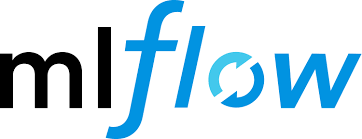

The process of developing, deploying, and maintaining models can be complex and challenging. This is where *MLflow*, an open-source platform, comes to the rescue. *MLflow* is designed to streamline and simplify the end-to-end machine learning lifecycle, making it easier for data scientists and engineers to manage their ML projects efficiently.

In [ ]:
!pip install mlflow[extras]

In [ ]:
import pandas as pd
import mlflow
import mlflow.sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from pprint import pprint
import warnings
warnings.filterwarnings("ignore")

###  Load the dataset and exploration

In [ ]:
df = pd.read_csv('diabetes.csv')

In [ ]:
df.sample(5)

,Id,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
1024,1025,3,111,56,39,0,30.1,0.557,30,0
105,106,1,126,56,29,152,28.7,0.801,21,0
352,353,3,61,82,28,0,34.4,0.243,46,0
1278,1279,12,84,72,31,0,29.7,0.297,46,1
1149,1150,0,105,68,22,0,20.0,0.236,22,0


In [ ]:
# Separate features (X) and target variable, Outcome (y).

X = df.drop(columns=['Outcome'])
y = df['Outcome']


In [ ]:
# Split data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 3. MLflow

In [ ]:
mlflow.sklearn.autolog()

The *mlflow.sklearn.autolog()* function is a utility provided by MLflow to automatically log scikit-learn model parameters and metrics during your machine learning experiments. It simplifies the process of tracking machine learning runs, making it easier to capture key information about your models and their performance.

Now we are going to build a simple Logistic Regression model to test out the MLflow tracking

In [ ]:
# Build and train a logistic regression model and start an MLflow run

with mlflow.start_run() as run:

    # Create and train a logistic regression model
    logistic_model = LogisticRegression(random_state=42)
    logistic_model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = logistic_model.predict(X_test)

    # Evaluate the model's performance
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    print(f"Accuracy: {accuracy:.2f}")
    print("Classification Report:\n", report)


Accuracy: 0.68
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.83      0.77       367
           1       0.53      0.39      0.45       187

    accuracy                           0.68       554
   macro avg       0.63      0.61      0.61       554
weighted avg       0.66      0.68      0.66       554



In [ ]:
def yield_artifacts(run_id, path=None):
    """Yield all artifacts in the specified run"""
    client = mlflow.tracking.MlflowClient()
    for item in client.list_artifacts(run_id, path):
        if item.is_dir:
            yield from yield_artifacts(run_id, item.path)
        else:
            yield item.path

The yield_artifacts function is a Python generator function that yields all artifacts (files and directories) associated with a specific MLflow run, specified by its run_id. It recursively traverses the directory structure of the run's artifacts.

The *yield_artifacts* generator function has two parameters:
1. run_id: The unique identifier of the MLflow run for which you want to retrieve artifacts
2. path (optional): The subdirectory path within the run's artifacts directory. This allows you to specify a specific subdirectory to start the traversal from. If not provided, the traversal starts from the root of the artifacts directory.

Then we create an instance of the MLflow tracking client and we are using a for loop to iterate over all the files


In [ ]:
def fetch_logged_data(run_id):
    """Fetch params, metrics, tags, and artifacts in the specified run"""
    client = mlflow.tracking.MlflowClient()
    data = client.get_run(run_id).data

    tags = {k: v for k, v in data.tags.items() if not k.startswith("mlflow.")}
    artifacts = list(yield_artifacts(run_id))
    return {
        "params": data.params,
        "metrics": data.metrics,
        "tags": tags,
        "artifacts": artifacts,
    }

The *fetch_logged_data* function retrieves various types of logged data associated with a specific MLflow run, specified by its run_id. It fetches and organizes information.

1. Parameters (params): Parameters used during the run, which typically include hyperparameters and model configuration settings.

2. Metrics (metrics): Performance metrics logged during the run, such as accuracy, precision, recall, and others.

3. Tags (tags): Custom tags and metadata associated with the run. It excludes tags that start with "mlflow.", which are MLflow-specific tags.

4. Artifacts (artifacts): Paths to artifacts (files and directories) associated with the run. These artifacts can include saved models, data files, visualizations, and more.


Now let's print out this info!

In [ ]:
for key, data in fetch_logged_data(run.info.run_id).items():
    print("\n---------- logged {} ----------".format(key))
    pprint(data)


---------- logged params ----------
{'C': '1.0',
 'class_weight': 'None',
 'dual': 'False',
 'fit_intercept': 'True',
 'intercept_scaling': '1',
 'l1_ratio': 'None',
 'max_iter': '100',
 'multi_class': 'auto',
 'n_jobs': 'None',
 'penalty': 'l2',
 'random_state': '42',
 'solver': 'lbfgs',
 'tol': '0.0001',
 'verbose': '0',
 'warm_start': 'False'}

---------- logged metrics ----------
{'accuracy_score_X_test': 0.6787003610108303,
 'training_accuracy_score': 0.7005420054200542,
 'training_f1_score': 0.6840432777484518,
 'training_log_loss': 0.5947876392739674,
 'training_precision_score': 0.6858233566413535,
 'training_recall_score': 0.7005420054200542,
 'training_roc_auc': 0.6979832834905298,
 'training_score': 0.7005420054200542}

---------- logged tags ----------
{'estimator_class': 'sklearn.linear_model._logistic.LogisticRegression',
 'estimator_name': 'LogisticRegression'}

---------- logged artifacts ----------
['estimator.html',
 'metric_info.json',
 'model/MLmodel',
 'model/cond

Check out the generated files in your environment.

In [ ]:
# End the MLflow run
mlflow.end_run()

By calling mlflow.end_run(), you finalize the current run, and MLflow stops recording information associated with that run. This makes it possible to start a new run with a clean context for a different experiment or iteration.

## MLflow GUI

Run the following command in your command line terminal to view the MLflow GUI:



> mlflow ui



## Exercises:

* Start the MLflow UI to view your runs and experiments

* Extend this exercise to log multiple runs of the same model with different hyperparameters. Use MLflow's tracking UI to compare results.

* Train a simple Keras neural network on a dataset, then modify the architecture and log it as a new version using MLflow.

* Experiment with integrating other machine learning libraries and frameworks with scikit-learn and Keras within MLflow.

* Implement hyperparameter tuning (Grid search, Randomized search).

* Use Git to add your finished notebook to your repo.

